In [112]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, RandomSampler
import numpy as np
import h5py
from tqdm import tqdm
from torch.autograd.variable import Variable
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib import cm


In [113]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10 means
                         std=[0.2470, 0.2435, 0.2616]),  # CIFAR-10 stds
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

num_samples = 100  # Specify number of random samples
sampler = RandomSampler(train_set, num_samples=num_samples)

train_loader = DataLoader(train_set, batch_size=32, sampler=sampler)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [114]:
# run to delete ./data so can be reimported
# import shutil
# import os

# # Path to the data directory
# data_dir = './data'

# if os.path.exists(data_dir):
#     shutil.rmtree(data_dir)
#     print(f"{data_dir} has been deleted.")
# else:
#     print(f"{data_dir} does not exist.")

In [115]:
def eval_loss(net, criterion, loader):
    """
    Args: net: the neural net model
        criterion: loss function
        loader: dataloader
    Returns: loss value and accuracy
    """
    correct = 0
    total_loss = 0
    total = 0 # number of samples
    num_batch = len(loader)

    net.eval()

    with torch.no_grad():
        if isinstance(criterion, nn.CrossEntropyLoss):
            for batch_idx, (inputs, targets) in enumerate(loader):
                batch_size = inputs.size(0)
                total += batch_size
                inputs, targets = inputs.to(device), targets.to(device)
                inputs = Variable(inputs)
                targets = Variable(targets)
                # if torch.isnan(inputs).any() or torch.isinf(inputs).any():
                #   print("NaN or Inf found in inputs")
                # if torch.isnan(targets).any() or torch.isinf(targets).any():
                #   print("NaN or Inf found in targets")
                outputs = net(inputs)
                # print("Logits stats — max:", outputs.max().item(),
                #       "min:", outputs.min().item(),
                #       "mean:", outputs.mean().item())
                # if torch.isnan(outputs).any() or torch.isinf(outputs).any():
                #   print("NaN or Inf found in outputs")
                loss = criterion(outputs, targets)
                #print(f'Batch Loss: {loss.item()}')
                total_loss += loss.item()*batch_size
                _, predicted = torch.max(outputs.data, 1)
                correct += predicted.eq(targets).sum().item()

        elif isinstance(criterion, nn.MSELoss):
            for batch_idx, (inputs, targets) in enumerate(loader):
                batch_size = inputs.size(0)
                inputs, targets = inputs.to(device), targets.to(device)
                total += batch_size
                inputs = Variable(inputs)

                one_hot_targets = torch.FloatTensor(batch_size, 10).zero_()
                one_hot_targets = one_hot_targets.scatter_(1, targets.view(batch_size, 1), 1.0)
                one_hot_targets = one_hot_targets.float()
                one_hot_targets = Variable(one_hot_targets)
                outputs = F.softmax(net(inputs))
                loss = criterion(outputs, one_hot_targets)
                total_loss += loss.item()*batch_size
                _, predicted = torch.max(outputs.data, 1)
                correct += predicted.cpu().eq(targets).sum().item()

    return total_loss/total, 100.*correct/total

In [116]:
resnet18model = models.resnet18(pretrained=True)
resnet18model.fc = nn.Linear(resnet18model.fc.in_features, 10)
resnet18model.eval().cuda()
print(resnet18model.fc)

loss_fn = torch.nn.CrossEntropyLoss()
alphas = np.linspace(-1, 1, 21)

def get_train_loss(model, loss_fn):
  # get training loss and accuracy for first graph
  train_losses, train_accuracies = [], []

  original_state = {k: v.clone() for k, v in model.state_dict().items()}
  direction = {}
  for k, v in model.state_dict().items():
      if torch.is_floating_point(v):
          direction[k] = torch.randn_like(v)
      else:
          direction[k] = torch.zeros_like(v)

  for alpha in tqdm(alphas):
      new_state = {k: original_state[k] + alpha * direction[k] for k in original_state}
      model.load_state_dict(new_state)

      total_loss = 0
      correct = 0
      total = 0

      with torch.no_grad():
        for inputs, targets in train_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

      avg_loss = total_loss / total
      acc = 100.0 * correct / total
      train_losses.append(avg_loss)
      train_accuracies.append(acc)
  return train_losses, train_accuracies

train_losses_resnet18, train_accuracies_resnet18 = get_train_loss(resnet18model, loss_fn)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=512, out_features=10, bias=True)


100%|██████████| 21/21 [00:05<00:00,  4.03it/s]


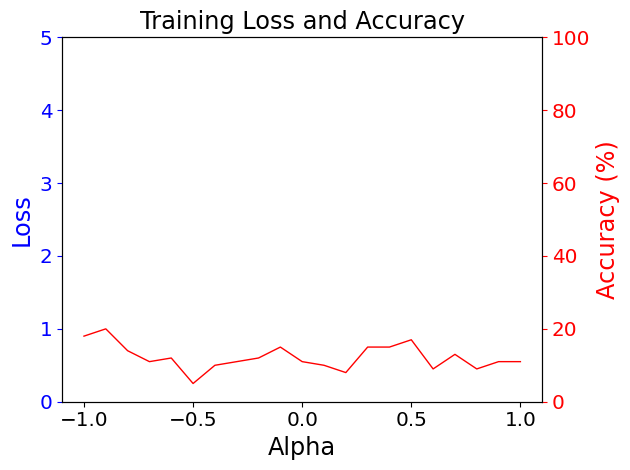

In [117]:
def plot_train_loss_accuracy(train_losses, train_accuracies, alphas, loss_max=5, log=False):
    fig, ax1 = plt.subplots()

    # Plot training loss on first y-axis
    if log:
        ax1.semilogy(alphas, train_losses, 'b-', label='Training loss', linewidth=1)
    else:
        ax1.plot(alphas, train_losses, 'b-', label='Training loss', linewidth=1)

    ax1.set_xlabel('Alpha', fontsize='xx-large')
    ax1.set_ylabel('Loss', color='b', fontsize='xx-large')
    ax1.tick_params('y', colors='b', labelsize='x-large')
    ax1.tick_params('x', labelsize='x-large')
    ax1.set_ylim(0, loss_max)

    # Create second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.plot(alphas, train_accuracies, 'r-', label='Training accuracy', linewidth=1)
    ax2.set_ylabel('Accuracy (%)', color='r', fontsize='xx-large')
    ax2.tick_params('y', colors='r', labelsize='x-large')
    ax2.set_ylim(0, 100)

    plt.title('Training Loss and Accuracy', fontsize='xx-large')
    plt.tight_layout()

    plt.show()

# Call function
plot_train_loss_accuracy(train_losses_resnet18, train_accuracies_resnet18, alphas, loss_max=5, log=False)


Progress: 10/100
Progress: 20/100
Progress: 30/100
Progress: 40/100
Progress: 50/100
Progress: 60/100
Progress: 70/100
Progress: 80/100
Progress: 90/100
Progress: 100/100


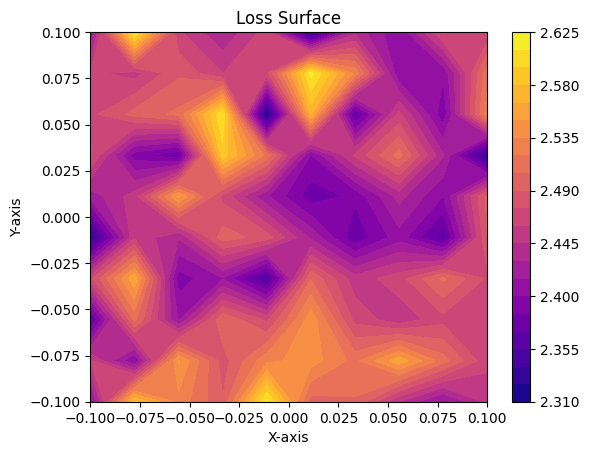

In [118]:
resnet18model = models.resnet18(pretrained=True)
resnet18model.fc = nn.Linear(resnet18model.fc.in_features, 10)
resnet18model.eval().cuda()

# Generate 2D Loss Surface
def plot_loss_surface(model, trainloader):
    x_values = np.linspace(-0.1, 0.1, 10)
    y_values = np.linspace(-0.1, 0.1, 10)
    loss_values = np.zeros((10, 10))
    acc_values = np.zeros((10, 10))

    for i, x in enumerate(x_values):
        for j, y in enumerate(y_values):
            # apply simple perturbation to the weights
            with torch.no_grad():
                for param in model.parameters():
                    param += x * torch.randn_like(param) * 0.01
                    param += y * torch.randn_like(param) * 0.01

            loss, acc = eval_loss(model, loss_fn, trainloader)
            loss_values[i, j] = loss
            acc_values[i, j] = acc
            if (i * len(y_values) + j + 1) % 10 == 0:
              print(f"Progress: {i * len(y_values) + j + 1}/{len(x_values) * len(y_values)}")

    X, Y = np.meshgrid(x_values, y_values)
    plt.contourf(X, Y, loss_values, 20, cmap='plasma')
    plt.colorbar()
    plt.title("Loss Surface")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()

    return X, Y, loss_values

# plotting
X, Y, loss_vals = plot_loss_surface(resnet18model, train_loader)

Progress: 10/100
Progress: 20/100
Progress: 30/100
Progress: 40/100
Progress: 50/100
Progress: 60/100
Progress: 70/100
Progress: 80/100
Progress: 90/100
Progress: 100/100


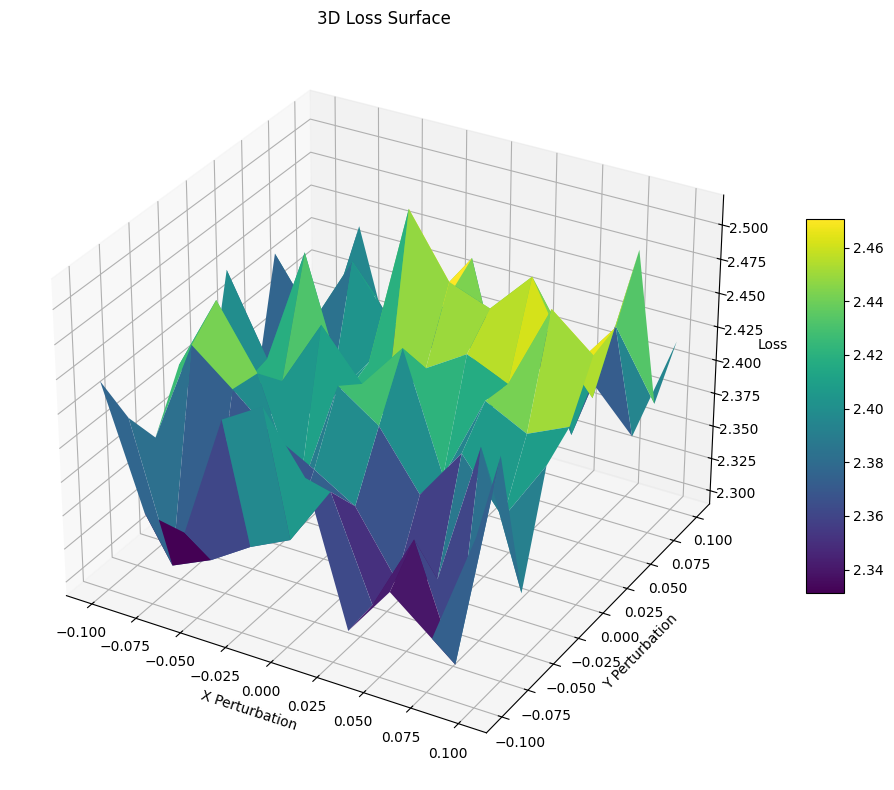

In [119]:
resnet18model = models.resnet18(pretrained=True)
resnet18model.fc = nn.Linear(resnet18model.fc.in_features, 10)
resnet18model.eval().cuda()

def plot_loss_surface_3d(model, trainloader):
    x_values = np.linspace(-0.1, 0.1, 10)
    y_values = np.linspace(-0.1, 0.1, 10)
    loss_values = np.zeros((10, 10))

    for i, x in enumerate(x_values):
        for j, y in enumerate(y_values):
            # apply changes to the model's weights or states
            with torch.no_grad():
                for param in model.parameters():
                    param += x * torch.randn_like(param) * 0.01
                    param += y * torch.randn_like(param) * 0.01

            loss, acc = eval_loss(model, loss_fn, trainloader)
            loss_values[i, j] = loss
            if (i * len(y_values) + j + 1) % 10 == 0:
              print(f"Progress: {i * len(y_values) + j + 1}/{len(x_values) * len(y_values)}")

    # Plot
    X, Y = np.meshgrid(x_values, y_values)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, loss_values, cmap='viridis', edgecolor='none')

    # labels and title
    ax.set_xlabel('X Perturbation')
    ax.set_ylabel('Y Perturbation')
    ax.set_zlabel('Loss')
    ax.set_title("3D Loss Surface")

    fig.colorbar(surf, shrink=0.5, aspect=10)

    plt.tight_layout()
    plt.show()

plot_loss_surface_3d(resnet18model, train_loader)


Linear(in_features=512, out_features=10, bias=True)


100%|██████████| 21/21 [00:06<00:00,  3.19it/s]


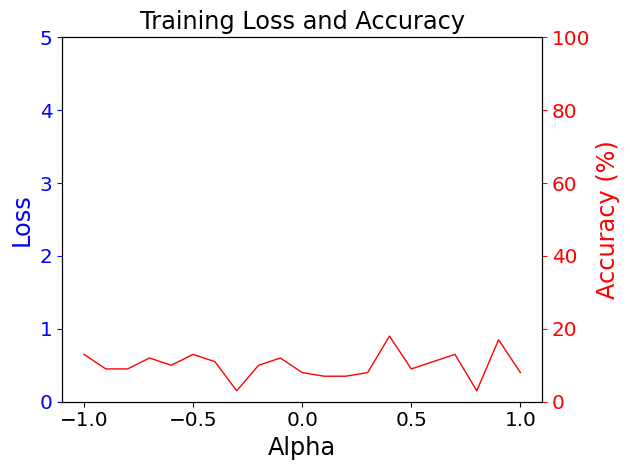

In [120]:
resnet34model = models.resnet34(pretrained=True)
resnet34model.fc = nn.Linear(resnet34model.fc.in_features, 10)
resnet34model.eval().cuda()
print(resnet34model.fc)

loss_fn = torch.nn.CrossEntropyLoss()
alphas = np.linspace(-1, 1, 21)

train_losses_resnet34, train_accuracies_resnet34 = get_train_loss(resnet34model, loss_fn)

plot_train_loss_accuracy(train_losses_resnet34, train_accuracies_resnet34, alphas, loss_max=5, log=False)

Progress: 10/100
Progress: 20/100
Progress: 30/100
Progress: 40/100
Progress: 50/100
Progress: 60/100
Progress: 70/100
Progress: 80/100
Progress: 90/100
Progress: 100/100


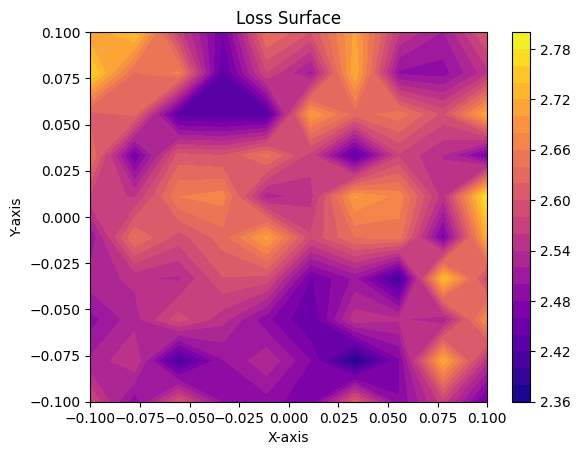

(array([[-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.03333333,  0.05555556,  0.07777778,  0.1       ],
        [-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.03333333,  0.05555556,  0.07777778,  0.1       ],
        [-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.03333333,  0.05555556,  0.07777778,  0.1       ],
        [-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.03333333,  0.05555556,  0.07777778,  0.1       ],
        [-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.03333333,  0.05555556,  0.07777778,  0.1       ],
        [-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.03333333,  0.05555556,  0.07777778,  0.1       ],
        [-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.0333333

In [121]:
resnet34model = models.resnet34(pretrained=True)
resnet34model.fc = nn.Linear(resnet34model.fc.in_features, 10)
resnet34model.eval().cuda()

# plotting
plot_loss_surface(resnet34model, train_loader)

Progress: 10/100
Progress: 20/100
Progress: 30/100
Progress: 40/100
Progress: 50/100
Progress: 60/100
Progress: 70/100
Progress: 80/100
Progress: 90/100
Progress: 100/100


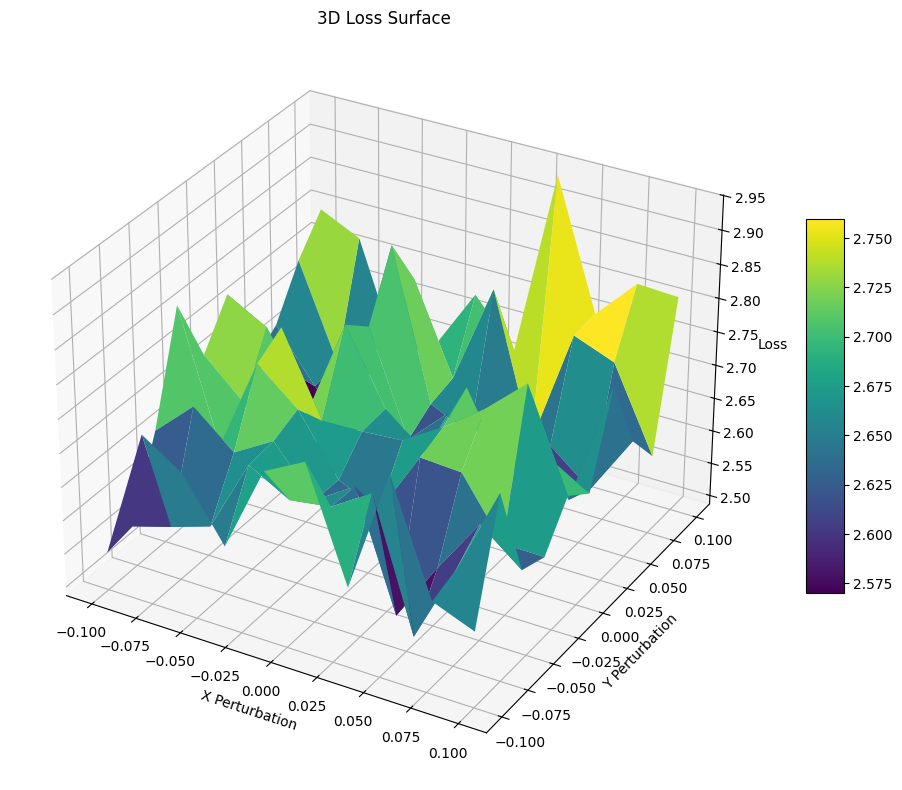

In [122]:
resnet34model = models.resnet34(pretrained=True)
resnet34model.fc = nn.Linear(resnet34model.fc.in_features, 10)
resnet34model.eval().cuda()

plot_loss_surface_3d(resnet34model, train_loader)


Linear(in_features=2048, out_features=10, bias=True)


100%|██████████| 21/21 [00:09<00:00,  2.32it/s]


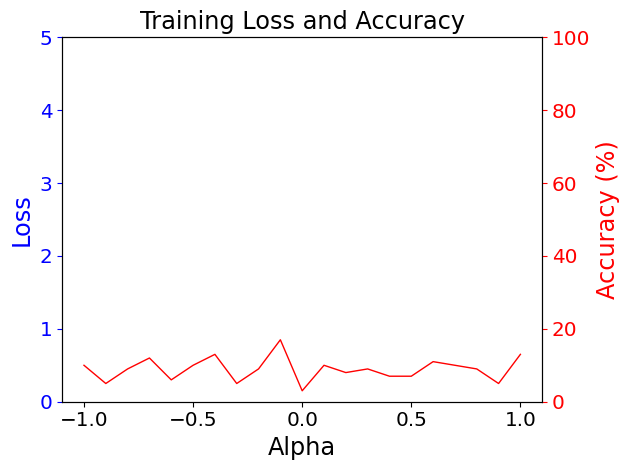

In [123]:
resnet50model = models.resnet50(pretrained=True)
resnet50model.fc = nn.Linear(resnet50model.fc.in_features, 10)
resnet50model.eval().cuda()
print(resnet50model.fc)

loss_fn = torch.nn.CrossEntropyLoss()
alphas = np.linspace(-1, 1, 21)

train_losses_resnet50, train_accuracies_resnet50 = get_train_loss(resnet50model, loss_fn)

plot_train_loss_accuracy(train_losses_resnet50, train_accuracies_resnet50, alphas, loss_max=5, log=False)

Progress: 10/100
Progress: 20/100
Progress: 30/100
Progress: 40/100
Progress: 50/100
Progress: 60/100
Progress: 70/100
Progress: 80/100
Progress: 90/100
Progress: 100/100


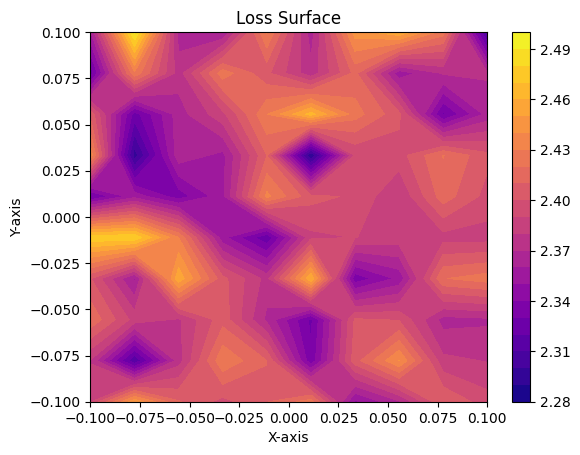

(array([[-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.03333333,  0.05555556,  0.07777778,  0.1       ],
        [-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.03333333,  0.05555556,  0.07777778,  0.1       ],
        [-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.03333333,  0.05555556,  0.07777778,  0.1       ],
        [-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.03333333,  0.05555556,  0.07777778,  0.1       ],
        [-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.03333333,  0.05555556,  0.07777778,  0.1       ],
        [-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.03333333,  0.05555556,  0.07777778,  0.1       ],
        [-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.0333333

In [124]:
resnet50model = models.resnet50(pretrained=True)
resnet50model.fc = nn.Linear(resnet50model.fc.in_features, 10)
resnet50model.eval().cuda()

# plotting
plot_loss_surface(resnet50model, train_loader)

Progress: 10/100
Progress: 20/100
Progress: 30/100
Progress: 40/100
Progress: 50/100
Progress: 60/100
Progress: 70/100
Progress: 80/100
Progress: 90/100
Progress: 100/100


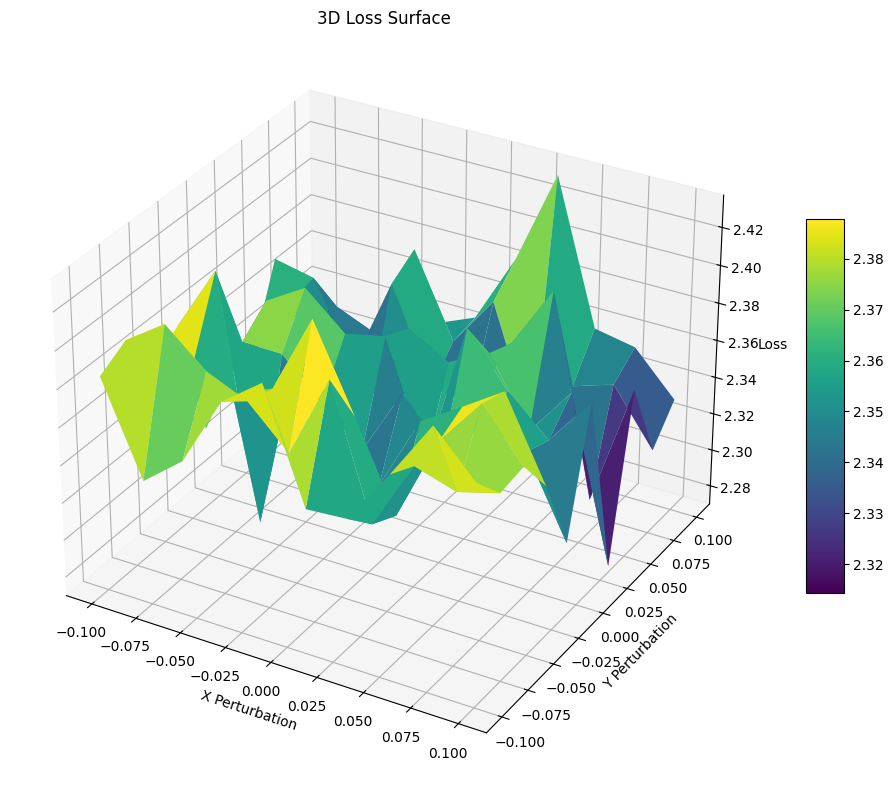

In [125]:
resnet50model = models.resnet50(pretrained=True)
resnet50model.fc = nn.Linear(resnet50model.fc.in_features, 10)
resnet50model.eval().cuda()

plot_loss_surface_3d(resnet50model, train_loader)


100%|██████████| 21/21 [00:14<00:00,  1.50it/s]


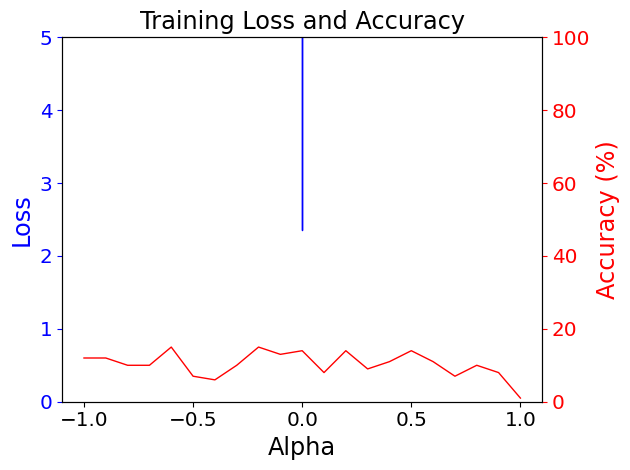

In [126]:
vgg16model = models.vgg16(pretrained=True)
vgg16model.classifier[6] = nn.Linear(vgg16model.classifier[6].in_features, 10)
vgg16model.eval().cuda()

loss_fn = torch.nn.CrossEntropyLoss()
alphas = np.linspace(-1, 1, 21)

train_losses_vgg16, train_accuracies_vgg16 = get_train_loss(vgg16model, loss_fn)

plot_train_loss_accuracy(train_losses_vgg16, train_accuracies_vgg16, alphas, loss_max=5, log=False)

Progress: 10/100
Progress: 20/100
Progress: 30/100
Progress: 40/100
Progress: 50/100
Progress: 60/100
Progress: 70/100
Progress: 80/100
Progress: 90/100
Progress: 100/100


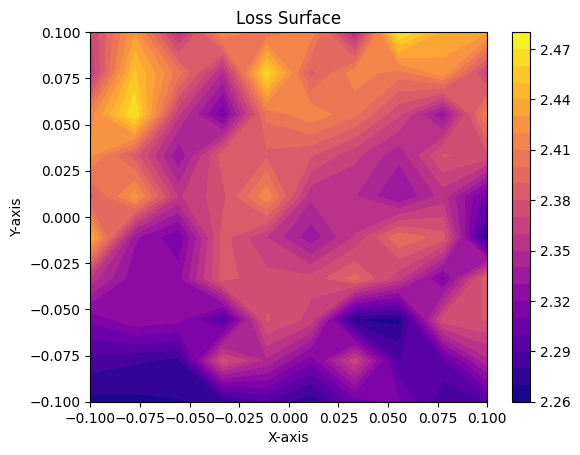

(array([[-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.03333333,  0.05555556,  0.07777778,  0.1       ],
        [-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.03333333,  0.05555556,  0.07777778,  0.1       ],
        [-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.03333333,  0.05555556,  0.07777778,  0.1       ],
        [-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.03333333,  0.05555556,  0.07777778,  0.1       ],
        [-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.03333333,  0.05555556,  0.07777778,  0.1       ],
        [-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.03333333,  0.05555556,  0.07777778,  0.1       ],
        [-0.1       , -0.07777778, -0.05555556, -0.03333333, -0.01111111,
          0.01111111,  0.0333333

In [127]:
vgg16model = models.vgg16(pretrained=True)
vgg16model.classifier[6] = nn.Linear(vgg16model.classifier[6].in_features, 10)
vgg16model.eval().cuda()

# plotting
plot_loss_surface(vgg16model, train_loader)

Progress: 10/100
Progress: 20/100
Progress: 30/100
Progress: 40/100
Progress: 50/100
Progress: 60/100
Progress: 70/100
Progress: 80/100
Progress: 90/100
Progress: 100/100


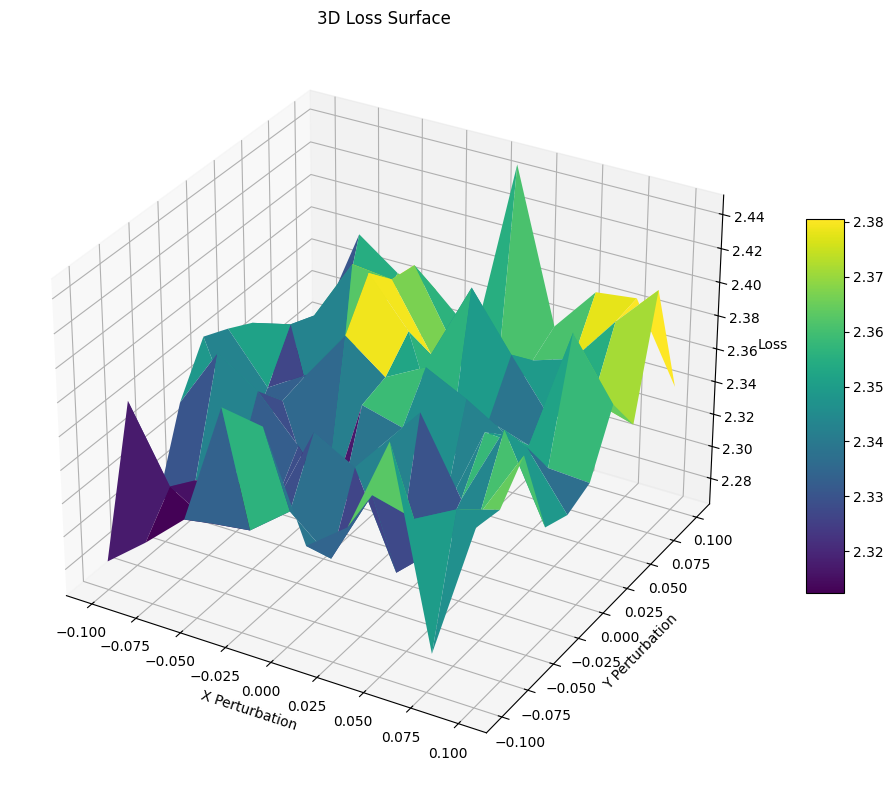

In [128]:
vgg16model = models.vgg16(pretrained=True)
vgg16model.classifier[6] = nn.Linear(vgg16model.classifier[6].in_features, 10)
vgg16model.eval().cuda()

plot_loss_surface_3d(vgg16model, train_loader)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 21/21 [00:10<00:00,  2.04it/s]


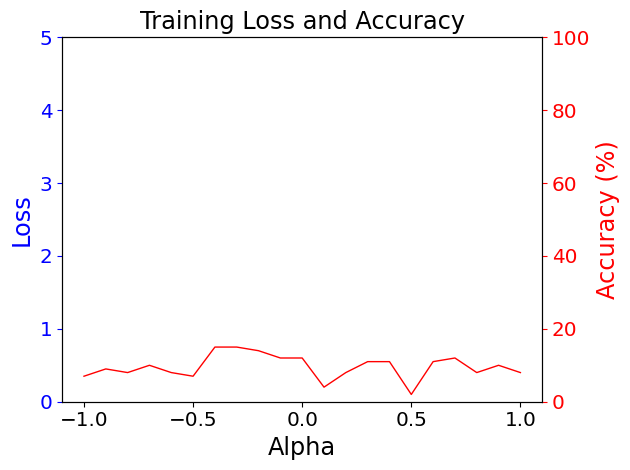

In [129]:
densenet121model = models.densenet121(pretrained=True)
num_features = densenet121model.classifier.in_features
densenet121model.classifier = nn.Linear(num_features, 10)
densenet121model.eval().cuda()

loss_fn = torch.nn.CrossEntropyLoss()
alphas = np.linspace(-1, 1, 21)


train_losses_densenet121, train_accuracies_densenet121 = get_train_loss(densenet121model, loss_fn)

plot_train_loss_accuracy(train_losses_densenet121, train_accuracies_densenet121, alphas, loss_max=5, log=False)

Progress: 10/100
Progress: 20/100
Progress: 30/100
Progress: 40/100
Progress: 50/100
Progress: 60/100
Progress: 70/100
Progress: 80/100
Progress: 90/100
Progress: 100/100


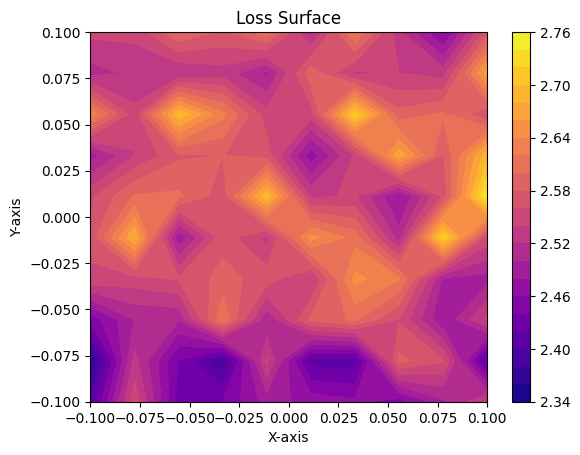

In [130]:
densenet121model = models.densenet121(pretrained=True)
num_features = densenet121model.classifier.in_features
densenet121model.classifier = nn.Linear(num_features, 10)
densenet121model.eval().cuda()

# plotting
X, Y, loss_vals = plot_loss_surface(densenet121model, train_loader)

In [131]:
# def estimate_smoothness_at_min(model, loss_fn, data_loader, loss_grid, x_values, y_values, epsilon=1e-6, max_attempts=5):
#     # Find min index from precomputed loss grid
#     min_i, min_j = np.unravel_index(np.argmin(loss_grid), loss_grid.shape)

#     # Get the perturbations corresponding to minimum point in grid
#     x_perturb = float(x_values[min_i])
#     y_perturb = float(y_values[min_j])

#     # Save original parameters
#     original_params = [p.clone().detach() for p in model.parameters() if p.requires_grad]

#     # Try multiple attempts with decreasing epsilon if needed
#     for attempt in range(max_attempts):
#         with torch.no_grad():
#             for p in model.parameters():
#                 if p.requires_grad:
#                     p.add_(epsilon * torch.randn_like(p))
#                     p.add_(x_perturb * torch.randn_like(p) * 0.01)
#                     p.add_(y_perturb * torch.randn_like(p) * 0.01)

#         # Compute gradients at perturbed point
#         model.zero_grad()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         inputs, targets = next(iter(data_loader))
#         inputs, targets = inputs.cuda(), targets.cuda()

#         outputs = model(inputs)
#         loss1 = loss_fn(outputs, targets)
#         grads1 = torch.autograd.grad(loss1, model.parameters(), create_graph=True)
#         grads1 = [g.detach() for g in grads1 if g is not None]

#         # Apply smaller perturbations
#         with torch.no_grad():
#             for p in model.parameters():
#                 if p.requires_grad:
#                     p.add_(x_perturb * torch.randn_like(p) * 0.01)
#                     p.add_(y_perturb * torch.randn_like(p) * 0.01)

#         # Compute gradients again after perturbations
#         model.zero_grad()
#         outputs = model(inputs)
#         loss2 = loss_fn(outputs, targets)
#         grads2 = torch.autograd.grad(loss2, model.parameters(), create_graph=True)
#         grads2 = [g.detach() for g in grads2 if g is not None]

#         # Compute gradient difference norm and parameter difference norm
#         grad_diff = torch.sqrt(sum(torch.norm(g1 - g2) ** 2 for g1, g2 in zip(grads1, grads2)))
#         param_diff = torch.sqrt(sum(torch.norm(p1 - p2) ** 2 for p1, p2 in zip(
#             original_params, [p for p in model.parameters() if p.requires_grad])))

#         # Check if numerical instability
#         if grad_diff.isinf() or grad_diff.isnan():
#             print(f"Numerical instability detected. Trying smaller epsilon: {epsilon}")
#             epsilon /= 2  # reduce epsilon and try again
#             continue

#         # return smoothness
#         smoothness = grad_diff / (param_diff + 1e-8)
#         return smoothness.item()

#     # if all attempts fail
#     print("Failed to compute stable smoothness estimate after multiple attempts.")
#     return float('nan')

# x_values = np.linspace(-0.1, 0.1, 10)
# y_values = np.linspace(-0.1, 0.1, 10)
# estimate_smoothness_at_min(densenet121model, loss_fn, train_loader, loss_vals, x_values, y_values)

Progress: 10/100
Progress: 20/100
Progress: 30/100
Progress: 40/100
Progress: 50/100
Progress: 60/100
Progress: 70/100
Progress: 80/100
Progress: 90/100
Progress: 100/100


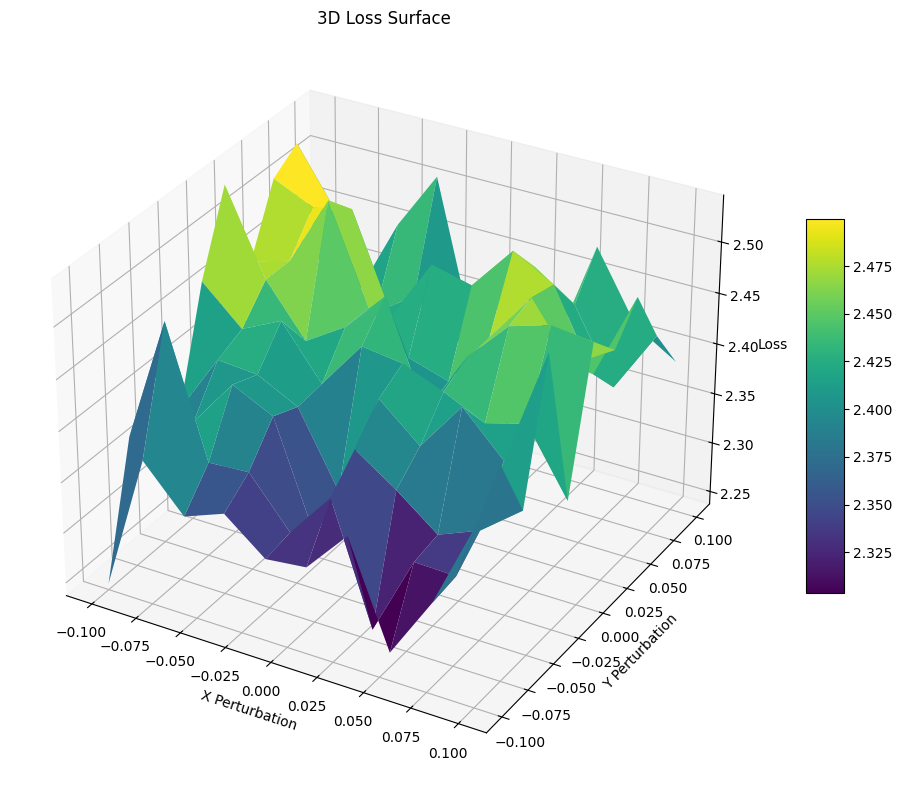

In [132]:
densenet121model = models.densenet121(pretrained=True)
num_features = densenet121model.classifier.in_features
densenet121model.classifier = nn.Linear(num_features, 10)
densenet121model.eval().cuda()

plot_loss_surface_3d(densenet121model, train_loader)


In [133]:
def compute_curvature(model, loss_fn, trainloader):
    model.train()
    total_curvature = 0
    num_batches = len(trainloader)

    for inputs, targets in trainloader:
        inputs, targets = inputs.cuda(), targets.cuda()

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Zero gradients
        model.zero_grad()

        # first derivative
        loss.backward(retain_graph=True)

        # Store gradients
        gradients = [param.grad.clone() for param in model.parameters()]

        # compute second-order derivatives
        hessian = 0
        for grad in gradients:
            hessian += torch.sum(grad ** 2)

        total_curvature += hessian.item()

    # Average curvature over all batches
    avg_curvature = total_curvature / num_batches
    return avg_curvature

In [134]:
resnet18model = models.resnet18(pretrained=True)
resnet18model.fc = nn.Linear(resnet18model.fc.in_features, 10)
resnet18model.eval().cuda()

curvature = compute_curvature(resnet18model, loss_fn, train_loader)
print(f"Curvature of the loss surface: {curvature}")


Curvature of the loss surface: 275.5316219329834


In [142]:
resnet34model = models.resnet34(pretrained=True)
resnet34model.fc = nn.Linear(resnet34model.fc.in_features, 10)
resnet34model.eval().cuda()

curvature = compute_curvature(resnet34model, loss_fn, train_loader)
print(f"Curvature of the loss surface: {curvature}")

Curvature of the loss surface: 531.0487976074219


In [136]:
resnet50model = models.resnet50(pretrained=True)
resnet50model.fc = nn.Linear(resnet50model.fc.in_features, 10)
resnet50model.eval().cuda()

curvature = compute_curvature(resnet50model, loss_fn, train_loader)
print(f"Curvature of the loss surface: {curvature}")

Curvature of the loss surface: 220.07643127441406


In [137]:
vgg16model = models.vgg16(pretrained=True)
vgg16model.classifier[6] = nn.Linear(vgg16model.classifier[6].in_features, 10)
vgg16model.eval().cuda()

curvature = compute_curvature(vgg16model, loss_fn, train_loader)
print(f"Curvature of the loss surface: {curvature}")

Curvature of the loss surface: 350.10511016845703


In [138]:
densenet121model = models.densenet121(pretrained=True)
num_features = densenet121model.classifier.in_features
densenet121model.classifier = nn.Linear(num_features, 10)
densenet121model.eval().cuda()

curvature = compute_curvature(densenet121model, loss_fn, train_loader)
print(f"Curvature of the loss surface: {curvature}")

Curvature of the loss surface: 440.29025650024414
